# Import niezbędnych bibliotek

In [1]:
import numpy as np
import helpers as hp
from copy import copy
import re
from os.path import exists, join, basename
from os import walk
import pandas as pd
from itertools import chain, product
import pingouin
import seaborn as sns
import rpy2
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

# Przygotowanie danych

## SUS

In [2]:
if exists("./sus.csv"):
    SUS_RAW = pd.read_csv("./sus.csv")
else:
    SPREADSHEET_ID = '1sbcSwWomc8dMuMjxxJ6_lY_BpGaOui2ICIojR30WDNk'
    RANGE = 'sus!A1:R46' # name of sheet, and selected cells
    SUS_RAW = hp.gsheet2df(hp.get_google_sheet(SPREADSHEET_ID, range=RANGE))
    SUS_RAW.to_csv("./sus.csv")
ID = "Unnamed: 0"
SUS_RAW

,Unnamed: 0,Sygnatura czasowa,Kod badanego,Testowany interfejs,1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu,2. Używanie tego sposobu było niepotrzebnie skomplikowane,3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe),"4. Potrzebował bym pomocy osoby ""technicznej"", aby używać tego sposobu kontroli.","5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.",6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości),"7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.","8. Sposób był ""nieporęczny"", niewygodny.",9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.,"10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.",Jakie elementy najbardziej przeszkadzały Ci w używaniu tego sposobu?,Jakie elementy były dobrze zaprojektowane (nie sprawiały kłopotów albo były przydatne)?,"Co można byłoby zmienić w tym sposobie kontroli odtwarzania filmu, aby go poprawić?"
0,0,2019-05-09 08:38:33,sub-07,Przyciski wzrokowe,raczej się nie zgadzam,zdecydowanie nie zgadzam się,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,nie mam zdania,zdecydowanie się zgadzam,raczej się nie zgadzam,Opóźnienie związane z odczytywaniem ruchu gałek,"Duże, przejrzyste przyciski oraz ich rozmieszc...","Brakuje przycisku blokady interfejsu, dzięki k..."
1,1,2019-05-09 08:57:25,sub-07,Obszary aktywowane spojrzeniem,raczej się nie zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,zdecydowanie się zgadzam,raczej się nie zgadzam,raczej się zgadzam,zdecydowanie nie zgadzam się,"Przęłączanie się między trybami, opóźnienie zw...","Duże, widoczne przyciski, prosta lista filmów ...","Dodać przycisk blokady interfejsu, wprowadzeni..."
2,2,2019-05-09 09:28:57,sub-07,Obszary aktywowane przemieszczeniem spojrzenia,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,raczej się nie zgadzam,nie mam zdania,raczej się nie zgadzam,raczej się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,nie mam zdania,"Niejasne zasady działania, brak reakcji progra...","Interfejs stop/play, lista filmów.","Poprawne rejestrowanie wzrosku, inne zasady dz..."
3,3,2019-05-11 08:46:31,sub-15,Obszary aktywowane spojrzeniem,raczej się nie zgadzam,raczej się nie zgadzam,raczej się nie zgadzam,raczej się zgadzam,nie mam zdania,nie mam zdania,raczej się zgadzam,raczej się nie zgadzam,raczej się nie zgadzam,raczej się nie zgadzam,"malo czytelne kontrolki od przewijania filmu, ...","wznawianie/zatrzymanie filmu, wypelniajacy sie...","zwiekszyłbym ikony po zatrzymaniu filmu, kontr..."
4,4,2019-05-11 09:03:19,sub-15,Przyciski wzrokowe,nie mam zdania,zdecydowanie nie zgadzam się,raczej się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,pozycja kursora nie zgrywała się z pozycją wzroku,"przyciski byly intuicyjne, obszar wypelniajacy...",wedlug mnie jest dobry
5,5,2019-05-11 09:25:59,sub-15,Obszary aktywowane przemieszczeniem spojrzenia,nie mam zdania,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,nie mam zdania,nie mam zdania,raczej się zgadzam,raczej się nie zgadzam,raczej się zgadzam,raczej się nie zgadzam,brak konsekwencji w uzywaniu przycisków - jeze...,sam pomysl z najezdzaniem i wyjezdzaniem jest ...,"zachować konsekwencje w aktywacji przycisków, ..."
6,6,2019-05-11 10:28:24,sub-01,Przyciski wzrokowe,raczej się zgadzam,zdecydowanie nie zgadzam się,raczej się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,zdecydowanie nie zgadzam się,zdecydowanie się zgadzam,raczej się nie zgadzam,zdecydowanie się zgadzam,zdecydo

In [3]:
"""
Values recoding
https://www.mysurveylab.com/pl/blog/skala-uzytecznosci-systemu-sus/
"""
negitve_columns = ['2. Używanie tego sposobu było niepotrzebnie skomplikowane',
                   '4. Potrzebował bym pomocy osoby "technicznej", aby używać tego sposobu kontroli.',
                   '6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości)',
                   '8. Sposób był "nieporęczny", niewygodny.',
                   '10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.']
positive_columns = ['1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu',
                    '3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe)',
                    '5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.',
                    '7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.',
                    '9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.']
sus_df = pd.DataFrame.copy(SUS_RAW)
positive = sus_df[chain(positive_columns, [ID, "Kod badanego", "Sygnatura czasowa", 'Testowany interfejs'])]
negative = sus_df[chain(negitve_columns, [ID, "Kod badanego", "Sygnatura czasowa", 'Testowany interfejs'])]
positive.replace(
    'zdecydowanie nie zgadzam się', 0,
    inplace=True)
positive.replace(
    'raczej się nie zgadzam', 1,
    inplace=True)
positive.replace(
    'nie mam zdania', 2,
    inplace=True)
positive.replace(
    'raczej się zgadzam', 3,
    inplace=True)
positive.replace(
    'zdecydowanie się zgadzam', 4,
    inplace=True)
negative.replace(
    'raczej się nie zgadzam', 3,
    inplace=True)
negative.replace(
    'zdecydowanie nie zgadzam się', 4,
    inplace=True)
negative.replace(
    'nie mam zdania', 2,
    inplace=True)
negative.replace(
    'raczej się zgadzam', 1,
    inplace=True)
negative.replace(
    'zdecydowanie się zgadzam', 0,
    inplace=True)
SUS_RECODED = pd.merge(positive, negative)
SUS_RECODED['Suma'] = SUS_RECODED[chain(positive_columns, negitve_columns)].sum(axis=1)
SUS_RECODED = SUS_RECODED[['Unnamed: 0', 'Sygnatura czasowa', 'Kod badanego',
                           'Testowany interfejs',
                           '1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu',
                           '2. Używanie tego sposobu było niepotrzebnie skomplikowane',
                           '3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe)',
                           '4. Potrzebował bym pomocy osoby "technicznej", aby używać tego sposobu kontroli.',
                           '5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.',
                           '6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości)',
                           '7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.',
                           '8. Sposób był "nieporęczny", niewygodny.',
                           '9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.',
                           '10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.',
                           'Suma']]
SUS_RECODED = hp.code_to_numeric(SUS_RECODED)
SUS_RECODED

/usr/lib/python3.7/site-packages/pandas/core/frame.py:4258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Unnamed: 0,Sygnatura czasowa,Kod badanego,Testowany interfejs,1. Chciałbym często używać tego sposobu kontroli odtwarzania filmu,2. Używanie tego sposobu było niepotrzebnie skomplikowane,3. Używanie tego sposobu nie sprawiało mi problemów (było łatwe),"4. Potrzebował bym pomocy osoby ""technicznej"", aby używać tego sposobu kontroli.","5. Poszczególne elementy kontroli były łatwo dostępne, tworzyły spójną całość.",6. Poszczególne elementy sposobu kontroli nie były ze sobą zgodne (nie tworzyły spójnej całości),"7. Uważam, że każdy może bardzo szybko nauczyć się używać tego sposobu kontroli odtwarzani filmu.","8. Sposób był ""nieporęczny"", niewygodny.",9. Czułem się pewnie używając tego sposobu kontroli odtwarzania. Jego działanie było przewidywalne i zgodne z intuicją.,"10. Musiałem nauczyć się sporo nowych rzeczy, aby móc używać tego sposobu kontroli odtwarzania filmu.",Suma
0,0,2019-05-09 08:38:33,7,Przyciski wzrokowe,1,4,3,3,3,3,3,2,4,3,29
1,1,2019-05-09 08:57:25,7,Obszary aktywowane spojrzeniem,1,3,3,3,3,3,4,3,3,4,30
2,2,2019-05-09 09:28:57,7,Obszary aktywowane przemieszczeniem spojrzenia,0,0,1,2,1,1,0,0,0,2,7
3,3,2019-05-11 08:46:31,15,Obszary aktywowane spojrzeniem,1,3,1,1,2,2,3,3,1,3,20
4,4,2019-05-11 09:03:19,15,Przyciski wzrokowe,2,4,3,4,4,4,4,4,4,4,37
5,5,2019-05-11 09:25:59,15,Obszary aktywowane przemieszczeniem spojrzenia,2,3,3,3,2,2,3,3,3,3,27
6,6,2019-05-11 10:28:24,1,Przyciski wzrokowe,3,4,3,4,4,4,4,3,4,4,37
7,7,2019-05-11 10:58:27,1,Obszary aktywowane spojrzeniem,4,4,4,3,4,4,4,4,4,4,39
8,8,2019-05-11 11:29:46,1,Obszary aktywowane przemieszczeniem spojrzenia,0,1,1,1,1,1,2,0,1,3,11
9,9,2019-05-12 10:07:23,9,Obszary aktywowane spojrzeniem,3,3,3,4,3,3,4,3,2,3,31


## Uszeregowanie interakcji

In [4]:
if exists("./szeregi.csv"):
    ranges = pd.read_csv("./szeregi.csv")
else:
    SPREADSHEET_ID = '1iVL1DVHoLT4BefZHhMaiUIjDH1Flii_KfxHkzZEU1Po'
    RANGE = 'szeregi!A1:L18' # [name of sheet]![selected cells]
    ranges = hp.gsheet2df(hp.get_google_sheet(SPREADSHEET_ID, range=RANGE))
    ranges.to_csv("./szerego.csv")
ranges.replace("Pomiędzy", 1, inplace=True)
ranges.replace("Najbardziej intuicyjne", 2, inplace=True)
ranges.replace("Najmniej intuicyjne", 0, inplace=True)
ranges.replace("Najmniej wygodna", 0, inplace=True)
ranges.replace("Najwygodniejsza", 2, inplace=True)
ranges.replace("Najmniej niezawodna", 0, inplace=True)
ranges.replace("Najbardziej niezawodna", 2, inplace=True)
ranges
RANGES = pd.DataFrame(columns=["Testowany interfejs", "Intuicyjność", "Wygoda", "Pewność"])
RANGES = RANGES.append({"Testowany interfejs": "Przyciski wzrokowe",
               "Intuicyjność": ranges["Pod względem intuicyjności (wybierz po jednej odpowiedzi w każdej kolumnie) [Przyciski wzrokowe]"].sum(),
                "Wygoda": ranges["Pod względem wygody używania (wybierz po jednej odpowiedzi w każdej kolumnie) [Przyciski wzrokowe]"].sum(),
                "Pewność": ranges["Pod względem pewności (wybierz po jednej odpowiedzi w każdej kolumnie) [Przyciski wzrokowe]"].sum()},
             ignore_index=True)
RANGES = RANGES.append({"Testowany interfejs": "Przyciski wzrokowe",
               "Intuicyjność": ranges["Pod względem intuicyjności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane spojrzeniem]"].sum(),
                "Wygoda": ranges["Pod względem wygody używania (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane spojrzeniem]"].sum(),
                "Pewność": ranges["Pod względem pewności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane spojrzeniem]"].sum()},
             ignore_index=True)
RANGES = RANGES.append({"Testowany interfejs": "Przyciski wzrokowe",
               "Intuicyjność": ranges["Pod względem intuicyjności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane przemieszczeniem spojrzenia]"].sum(),
                "Wygoda": ranges["Pod względem wygody używania (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane przemieszczeniem spojrzenia]"].sum(),
                "Pewność": ranges["Pod względem pewności (wybierz po jednej odpowiedzi w każdej kolumnie) [Obszary aktywowane przemieszczeniem spojrzenia]"].sum()},
             ignore_index=True)
RANGES


,Testowany interfejs,Intuicyjność,Wygoda,Pewność
0,Przyciski wzrokowe,25,22,22
1,Przyciski wzrokowe,16,18,18
2,Przyciski wzrokowe,4,5,5


## Testy poznawcze

In [5]:
COGNITIVE_TESTS = pd.read_csv("testy_poznawcze.csv", delimiter=";")
COGNITIVE_TESTS['Nazwisko osoby'] = COGNITIVE_TESTS['Nazwisko osoby'].apply(lambda x: x.split(" ")[0])
COGNITIVE_TESTS.columns = chain(['Kod badanego'], COGNITIVE_TESTS.columns[1:])
COGNITIVE_TESTS = hp.code_to_numeric(COGNITIVE_TESTS)
COGNITIVE_TESTS['ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym'] = [2571,
2634,
2523,
1082,
1266,
2717,
2436,
2080,
np.nan,
2430,
2588,
2631,
2789,
2643,
1229]
COGNITIVE_TESTS

,Kod badanego,Data urodzenia,Czas trwania testu w minutach,Płeć,Wykształcenie,CORSI/S3 RawScore - BT - Wartość surowa Czas trwania testu,CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej,CORSI/S3 RawScore - SBS - Wartość surowa Rozpiętość blokowa supra,CORSI/S3 RawScore - SBSA - Wartość surowa Opuszczone (SBS),CORSI/S3 RawScore - SBSF - Wartość surowa Błędne (SBS),...,ZBA/S3 RawScore - MEDDFK - Wartość surowa Mediana odchylenia kierunku przy torze złożonym,ZBA/S3 RawScore - MEDTF - Wartość surowa Mediana odchylenia czasowego łącznie,ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym,APM/S1 RawScore - BT - Wartość surowa Working time,APM/S1 RawScore - GW - Wartość surowa Total number of correct answers,APM/S1 RawScore - SET1 - Wartość surowa Correct set I,APM/S1 RawScore - SET2 - Wartość surowa Correct set II,3D/S1 RawScore - BT - Wartość surowa Czas trwania testu,3D/S1 RawScore - CA - Wartość surowa Prawidłowe odpowiedzi,3D/S1 RawScore - WA - Wartość surowa Nieprawidłowe odpowiedzi
0,2,19910409,01:20:14,kobiety,5 = ukończone studia wyższe,1116.0,5.0,2.0,1.0,10.0,...,NaN,NaN,2571.0,2571.0,41.0,11.0,30.0,180,17,0
1,13,19960331,01:25:43,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,360.0,4.0,1.0,0.0,5.0,...,NaN,NaN,2634.0,2634.0,27.0,9.0,18.0,180,12,2
2,12,19970118,01:18:13,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,432.0,6.0,NaN,NaN,NaN,...,NaN,NaN,2523.0,2523.0,40.0,12.0,28.0,179,17,7
3,10,19981231,00:55:41,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,918.0,7.0,2.0,0.0,6.0,...,NaN,NaN,1082.0,1082.0,42.0,12.0,30.0,170,21,9
4,16,19980428,00:56:12,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,689.0,4.0,2.0,0.0,8.0,...,NaN,NaN,1266.0,1266.0,33.0,12.0,21.0,180,17,3
5,4,19940718,01:22:33,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,811.0,7.0,1.0,0.0,7.0,...,NaN,NaN,2717.0,2717.0,41.0,11.0,30.0,177,16,0
6,6,19961220,01:21:29,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,983.0,6.0,0.0,0.0,7.0,...,NaN,NaN,2436.0,2436.0,37.0,12.0,25.0,181,19,5
7,11,19980314,01:02:59,kobiety,4 = ukończona szkoła ponadgimnazjalna z maturą...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2080.0,2080.0,38.0,12.0,26.0,181,11,4
8,7,19980501,00:36:55,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,941.0,5.0,3.0,0.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,14,4
9,15,19970729,01:19:05,mężczyzna,4 = ukończona szkoła ponadgimnazjalna z maturą...,731.0,5.0,0.0,0.0,7.0,...,NaN,NaN,2430.0,2430.0,42.0,12.0,30.0,179,20,3


## Eyetracking

In [6]:
# TODO: wget script
def get_eyetracking_data_paths(starting_path, current_subject=None):
    sub = None
    task = None
    for root, dirs, files in walk(starting_path, topdown=True):
        if re.search(r'\d+$', root) is not None:
            sub = root.split("\\")[-1]
        elif root.endswith("dwell-time_buttons"):
            task = "dwell-time_buttons"
        elif root.endswith("dwell-time_regions"):
            task = "dwell-time_regions"
        elif root.endswith("enter-and-leave_regions"):
            task = "enter-and-leave_regions"
        for file in files:
            if file == "processed.csv":
                yield sub, task, join(root, file)

_translation_dict = {"dwell-time_buttons": "Przyciski wzrokowe",
                     "dwell-time_regions": "Obszary aktywowane spojrzeniem",
                     "enter-and-leave_regions": "Obszary aktywowane przemieszczeniem spojrzenia"}
create_header = True
for sub, task, data_file_path in get_eyetracking_data_paths("./eyetracking_data"):
    data = pd.read_csv(data_file_path)
    data['Kod badanego'] = basename(sub)
    data['Testowany interfejs'] = _translation_dict[task]
    cc = list(copy(data.columns))
    cc.remove("Unnamed: 0")
    data = data[cc]
    if create_header:
        data.to_csv("time_series.csv", mode="w", header=True, index=False)
        create_header=False
    data.to_csv("time_series.csv", mode="a", header=False, index=False)
EYETRACKING_DATA = pd.read_csv("time_series.csv")
EYETRACKING_DATA = hp.code_to_numeric(EYETRACKING_DATA)
# EYETRACKING_DATA

Szeregi czasowe zostały znormalizowane wewnątrz zadania i wewnątrz grupy

In [7]:
EYETRACKING_DATA_STD = pd.DataFrame.copy(EYETRACKING_DATA)
def normalize(x):
    x['Duration']  = (x['Duration'] - x['Duration'].min()) / (x['Duration'].max() - x['Duration'].min()) 
    return x
def standardize(x):
    x['Duration']  = (x['Duration'] - x['Duration'].mean()) / x['Duration'].std()  
    return x
def sum_one(x):
    x['Duration']  = x['Duration']/x['Duration'].sum()
    return x
for task in EYETRACKING_DATA['Task name'].unique():
    for interface in EYETRACKING_DATA['Testowany interfejs'].unique():
        cond=lambda task, interface :(EYETRACKING_DATA_STD['Task name'] == task) & (EYETRACKING_DATA_STD['Testowany interfejs'] == interface)
        to_normalize = normalize(EYETRACKING_DATA_STD[cond(task, interface)])
        EYETRACKING_DATA_STD = EYETRACKING_DATA_STD.mask(cond = cond(task, interface), other=to_normalize, axis=0)
EYETRACKING_DATA_STD = EYETRACKING_DATA_STD
# EYETRACKING_DATA_STD

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


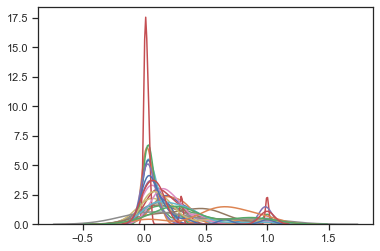

In [8]:
#([EYETRACKING_DATA_STD[cond(task, interface)]['Duration'].dropna()] for task in EYETRACKING_DATA_STD['Task name'].unique() for interface in EYETRACKING_DATA_STD['Testowany interfejs']])
args = [[EYETRACKING_DATA_STD[cond(*pair)]['Duration']] for pair in product(EYETRACKING_DATA_STD['Task name'].unique(), EYETRACKING_DATA_STD['Testowany interfejs'].unique())]
for arg in args:
    sns.distplot(arg, hist=False)
    

In [9]:
COGNITIVE_TESTS[['Kod badanego', 'CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej']]

,Kod badanego,CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej
0,2,5.0
1,13,4.0
2,12,6.0
3,10,7.0
4,16,4.0
5,4,7.0
6,6,6.0
7,11,NaN
8,7,5.0
9,15,5.0


In [66]:
h7_data = pd.merge(EYETRACKING_DATA_STD[['Kod badanego', 'Testowany interfejs', 'Duration', 'Number of errors']],
                   SUS_RECODED[['Kod badanego', 'Suma']], 
                   on="Kod badanego")
cond=lambda sub, interface :(SUS_RECODED['Kod badanego'] == sub) & (SUS_RECODED['Testowany interfejs'] == interface)
cond2=lambda sub, interface :(h7_data['Kod badanego'] == sub) & (h7_data['Testowany interfejs'] == interface)
h7_data_processed = pd.DataFrame(columns=['Kod badanego', 'Testowany interfejs', 'SUS', 'Sum of weighted time', 'Sum of errors', 'Sum of time'])
for sub in h7_data['Kod badanego'].unique():
    for interface in h7_data['Testowany interfejs'].unique():
        temp = pd.DataFrame([[sub, 
                              interface, 
                              SUS_RECODED[cond(sub, interface)]['Suma'].values[0], 
                              h7_data[cond2(sub,interface)]['Duration'].sum(), 
                              h7_data[cond2(sub,interface)]['Number of errors'].sum(),
                              EYETRACKING_DATA.where(EYETRACKING_DATA['Kod badanego'] == sub).where(EYETRACKING_DATA['Testowany interfejs'] == interface)['Duration'].sum()]],
                              columns=h7_data_processed.columns)
        h7_data_processed = pd.concat([h7_data_processed, temp])
h7_data_processed = h7_data_processed.where(h7_data_processed['Sum of weighted time'] > 0).dropna()
# droping subjects that had less than 3 tasks
EYETRACKING_SUMMARY= h7_data_processed.where(h7_data_processed['Kod badanego'] != 3).where(h7_data_processed['Kod badanego'] != 2).where(h7_data_processed['Kod badanego'] != 8).dropna()
for sub in EYETRACKING_SUMMARY['Kod badanego'].unique():
    if len(EYETRACKING_SUMMARY[EYETRACKING_SUMMARY['Kod badanego'] == sub]) != 3:
        print(f"misisng data at {sub}")
EYETRACKING_SUMMARY = pd.merge(EYETRACKING_SUMMARY,
                               COGNITIVE_TESTS[['Kod badanego', 
                                                'CORSI/S3 RawScore - RSS - Wartość surowa Parametr częściowy: wiarygodna pojemność pamięci przestrzennej',
                                               ]],
                              on="Kod badanego")

EYETRACKING_SUMMARY.columns = list(chain(EYETRACKING_SUMMARY.columns[:-1], ['CORSI']))
EYETRACKING_SUMMARY['Sum of errors'] = EYETRACKING_SUMMARY['Sum of errors'].values.astype(float)
EYETRACKING_SUMMARY['SUS'] = EYETRACKING_SUMMARY['SUS'].values.astype(int)
# EYETRACKING_SUMMARY

## Dane osobowe

In [11]:
if exists("./osobowe.csv"):
    PERSONAL_DATA = pd.read_csv("./osobowe.csv")
else:
    SPREADSHEET_ID = '1a6J_P-5dPknHRX5_s5oBQm79p-dz2XILF9EKsfX3AJQ'
    RANGE = 'osobowe!A1:G46' # name of sheet, and selected cells
    PERSONAL_DATA = hp.gsheet2df(hp.get_google_sheet(SPREADSHEET_ID, range=RANGE))
    PERSONAL_DATA.to_csv("./osobowe.csv")
ID = "Unnamed: 0"
PERSONAL_DATA = hp.code_to_numeric(PERSONAL_DATA)
# PERSONAL_DATA

# Weryfikacja hipotez

## Różnice pomiędzy interfejsami - SUS

In [12]:
# Normality check
pingouin.normality(dv="Suma",
                   group="Testowany interfejs",
                   data=SUS_RECODED)

,W,pval,normal
Przyciski wzrokowe,0.882867,0.052368,True
Obszary aktywowane spojrzeniem,0.927581,0.251007,True
Obszary aktywowane przemieszczeniem spojrzenia,0.891679,0.071101,True


In [13]:
# Repeated measures ANOVA documentation
# https://pingouin-stats.org/generated/pingouin.rm_anova.html#pingouin.rm_anova
print(pingouin.rm_anova(dv="Suma", 
                  within="Testowany interfejs",
                  subject="Kod badanego",
                  data=SUS_RECODED,
                  detailed=True))


                Source        SS  DF       MS       F        p-unc    np2  \
0  Testowany interfejs   784.933   2  392.467  10.791  0.000335578  0.435   
1                Error  1018.400  28   36.371       -            -      -   

     eps  
0  0.897  
1      -  


In [14]:
pingouin.pairwise.pairwise_ttests(dv="Suma", 
                                  within="Testowany interfejs",
                                  subject="Kod badanego",
                                  data=SUS_RECODED)

,Contrast,A,B,Paired,Parametric,T,dof,tail,p-unc,BF10,CLES,hedges
0,Testowany interfejs,Przyciski wzrokowe,Obszary aktywowane spojrzeniem,True,True,1.036,14.0,two-sided,0.317640,0.415,0.587,0.314
1,Testowany interfejs,Przyciski wzrokowe,Obszary aktywowane przemieszczeniem spojrzenia,True,True,4.440,14.0,two-sided,0.000560,63.795,0.782,1.183
2,Testowany interfejs,Obszary aktywowane spojrzeniem,Obszary aktywowane przemieszczeniem spojrzenia,True,True,3.074,14.0,two-sided,0.008245,6.53,0.756,0.960


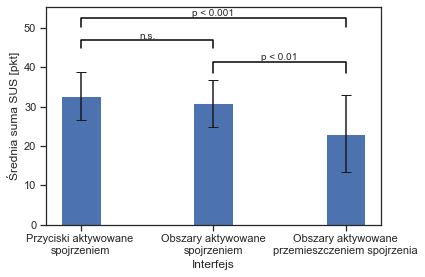

In [15]:
x = SUS_RECODED['Testowany interfejs'].unique()
y = np.array([ np.array(SUS_RECODED[SUS_RECODED['Testowany interfejs'] == a]['Suma'].mean()) for a in x])
yerr = np.array([SUS_RECODED[SUS_RECODED['Testowany interfejs'] == a]['Suma'].std() for a in x])
a = plt.bar(['Przyciski aktywowane \nspojrzeniem', 'Obszary aktywowane\nspojrzeniem', 'Obszary aktywowane\nprzemieszczeniem spojrzenia'], y, color='b', yerr=yerr, width=0.3, capsize=5)
plt.ylabel('Średnia suma SUS [pkt]')
plt.xlabel('Interfejs')
hp.barplot_annotate_brackets(0,1, 'n.s.', np.arange(len(y)), y+10)
hp.barplot_annotate_brackets(0,2, 'p < 0.001', np.arange(len(y)), y+15)
hp.barplot_annotate_brackets(1,2, 'p < 0.01', np.arange(len(y)), y+5)
plt.savefig('sus_plot.png', dpi=1000, paper='a4')
plt.show()

## Różnice w czasie wykonania poszczególnych zadań pomiędzy badanymi

In [16]:
# data = data[data['Kod badanego'].isin([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])]
for task in data['Task name'].unique():
    temp = data[data['Task name'] == task]
    print(task)
#     %R -i temp
#     %R library('ez')
#     %R result = ezANOVA(data=temp, dv=Duration, wid=Kod.badanego, within=Testowany.interfejs, within_full=Testowany.interfejs, detailed=TRUE, type=3)
#     %R print(result)
#     %R -i temp
#     %R library('ez')
#     %R result = ezDesign(data=temp, x=Duration, y=Kod.badanego, row=Testowany.interfejs)
#     %R print(result)

FeedForward
Rewind
ReduceVolume
PauseAndResume
SetVideo
IncreaseVolume
SetPanelAndVideo
Pause


Spore braki w danych i brak spójności bazy

## Hipoteza 1: różne osoby w zależności od temperamentu i inteligencji mogą preferować różne interfejsy aplikacji

Hipoteza związana z temperamentem jest nieweryfikowalna ze względu na braki w danych

In [17]:
h1_data = pd.merge(SUS_RECODED[['Kod badanego', 
                                'Testowany interfejs', 'Suma']], 
                   COGNITIVE_TESTS[['Kod badanego', 
                                    'APM/S1 RawScore - GW - Wartość surowa Total number of correct answers']], 
                   on="Kod badanego")
h1_data = h1_data.dropna()
h1_data.columns = chain(h1_data.columns[:-1], ['Raven'])
h1_data

,Kod badanego,Testowany interfejs,Suma,Raven
3,15,Obszary aktywowane spojrzeniem,20,42.0
4,15,Przyciski wzrokowe,37,42.0
5,15,Obszary aktywowane przemieszczeniem spojrzenia,27,42.0
6,1,Przyciski wzrokowe,37,36.0
7,1,Obszary aktywowane spojrzeniem,39,36.0
8,1,Obszary aktywowane przemieszczeniem spojrzenia,11,36.0
9,9,Obszary aktywowane spojrzeniem,31,45.0
10,9,Przyciski wzrokowe,34,45.0
11,9,Obszary aktywowane przemieszczeniem spojrzenia,17,45.0
12,2,Przyciski wzrokowe,34,41.0


R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



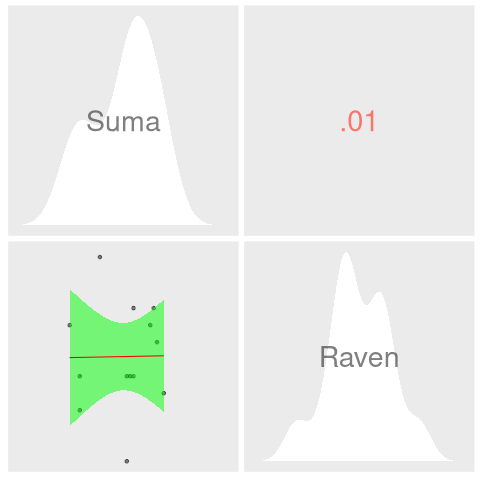

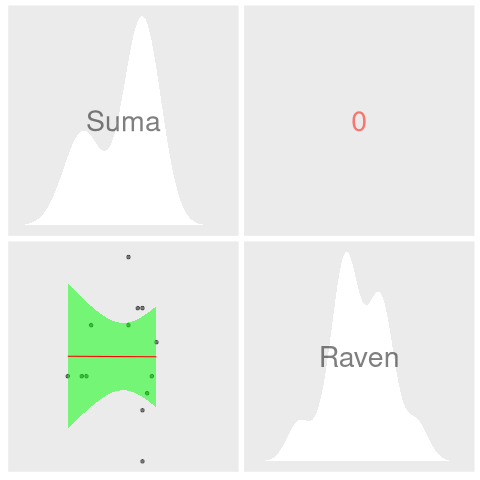

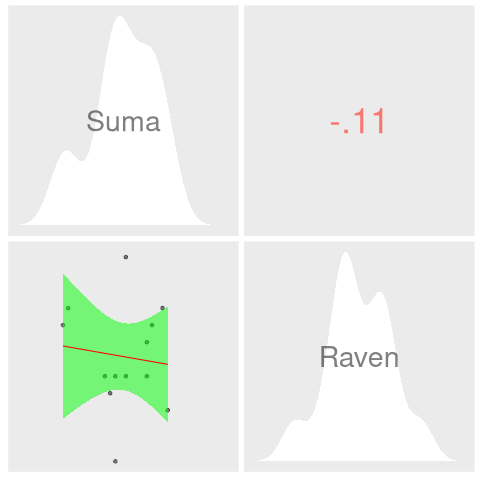

In [18]:
temp = h1_data[h1_data['Testowany interfejs'] == 'Obszary aktywowane przemieszczeniem spojrzenia'][['Suma', 'Raven']]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
temp = h1_data[h1_data['Testowany interfejs'] == 'Przyciski wzrokowe'][['Suma', 'Raven']]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
temp = h1_data[h1_data['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem'][['Suma', 'Raven']]
%R -i temp
%R library('ez')
%R resutl = ezCor(temp)
%R print(resutl)
pass

## Hipoteza obalona - nie ma istotnych korelacji między inteligencją, a oceną interfejsu w żadnej z 3 grup

## Hipoteza 2: osoby o większej rozpiętości pamięci lepiej będą radziły sobie z interfejsami wymagającymi zapamiętania lokalizacji

In [19]:
h3_data = EYETRACKING_SUMMARY[EYETRACKING_SUMMARY['Testowany interfejs'] != 'Przyciski wzrokowe']
%R -i h3_data
%R library('rmcorr')
%R corr = rmcorr(participant=Kod.badanego, measure1=Sum.of.time, measure2=CORSI, dataset=h3_data)
%R print(corr)
%R corr = rmcorr(participant=Kod.badanego, measure1=Sum.of.errors, measure2=CORSI, dataset=h3_data)
%R print(corr)


Repeated measures correlation

r
-0.3632625

degrees of freedom
8

p-value
0.3021817

95% confidence interval
-0.8502798 0.4588734
Repeated measures correlation

r
-0.001552313

degrees of freedom
8

p-value
0.9966043

95% confidence interval
-0.7054536 0.7038906

## Hipoteza obalona - rozpiętość pamięciowa nie ma wpływu na wyniki osiagane w poszczególnych interfejsach

## Hipoteza 3: osoby w lepszą zdolnością antycypacji czasowo-przestrzennej będą lepiej sobie radziły w interfejsie aktywowanym przemieszczeniem spojrzenia

In [20]:
h3_data = EYETRACKING_SUMMARY.where(EYETRACKING_SUMMARY['Testowany interfejs'] == 'Obszary aktywowane przemieszczeniem spojrzenia').dropna()
h3_data = pd.merge(h3_data[['Kod badanego', 'Sum of errors', 'Sum of time']],
                   COGNITIVE_TESTS[['Kod badanego',
                                        'ZBA/S3 RawScore - MEDTF1 - Wartość surowa Mediana odchylenia czasowego przy torze prostoliniowym',
                                    'ZBA/S3 RawScore - MEDDF4 - Wartość surowa Mediana odchylenia kierunku']],
                   on='Kod badanego').dropna()
h3_data.columns = ['Kod badanego', 'Errors', 'Time', 'Dev Median Time', 'Dev Median Distance']
h3_data['Errors'] = h3_data['Errors'].astype(int)
# h3_data = h3_data[h3_data.columns[1:]]
pingouin.pairwise_corr(h3_data, columns=[['Dev Median Time', 'Dev Median Distance'], ['Errors', 'Time']], padjust='bonf', method='pearson', tail='one-sided')

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power
0,Dev Median Time,Errors,pearson,one-sided,8,0.428,"[-0.4, 0.87]",0.183,-0.143,0.457,0.144983,0.579932,bonf,1.164,0.296
1,Dev Median Time,Time,pearson,one-sided,8,-0.592,"[-0.92, 0.19]",0.351,0.091,-0.681,0.060968,0.243873,bonf,2.229,0.496
2,Dev Median Distance,Errors,pearson,one-sided,8,-0.745,"[-0.95, -0.09]",0.555,0.378,-0.962,0.016919,0.067674,bonf,5.728,0.740
3,Dev Median Distance,Time,pearson,one-sided,8,-0.483,"[-0.89, 0.34]",0.234,-0.073,-0.527,0.112498,0.449992,bonf,1.411,0.356


## Hipoteza 4: lepsze zdolności wyobrażeniowe ułatwiają korzystanie z interfejsów wykorzystujących obszary wykraczające poza ekran,

## Hipoteza 5: korzystając z interfejsu obszarów aktywowanych spojrzeniem użytkownicy popełniają mniej błędów niż w interfejsie przycisków aktywowanych spojrzeniem

In [30]:
h5_data = pd.DataFrame.copy(EYETRACKING_SUMMARY)
print(pingouin.normality(data=h5_data, dv="Sum of errors", group="Testowany interfejs"))
x = h5_data[h5_data["Testowany interfejs"] == "Obszary aktywowane spojrzeniem"]['Sum of errors'].values
y = h5_data[h5_data["Testowany interfejs"] == "Przyciski wzrokowe"]['Sum of errors'].values
print(pingouin.ttest(x=x, 
                     y=y,
                     paired=True, tail='two-sided'))
print(h5_data[h5_data['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem']['Sum of errors'].mean(), '+-', h5_data[h5_data['Testowany interfejs'] == 'Obszary aktywowane spojrzeniem']['Sum of errors'].std())
print(h5_data[h5_data['Testowany interfejs'] == 'Przyciski wzrokowe']['Sum of errors'].mean(), '+-', h5_data[h5_data['Testowany interfejs'] == 'Przyciski wzrokowe']['Sum of errors'].std())

                                                       W      pval  normal
Przyciski wzrokowe                              0.843864  0.063751    True
Obszary aktywowane spojrzeniem                  0.876994  0.145960    True
Obszary aktywowane przemieszczeniem spojrzenia  0.889632  0.197796    True
            T  dof       tail     p-val           CI95%  cohen-d   BF10  power
T-test -1.793    8  two-sided  0.110801  [-57.16, 7.16]    0.397  1.019  0.183
64.0 +- 49.658836071740545
89.0 +- 76.22007609547501


## Hipoteza obalona - nie ma istotnych różnic w ilości popełnionych błędów pomiędzy pzyciskami wzrokowymi i obszarami aktywowanymi spojrzeniem. Jednakże średnia ilość błędów popełnionych podczas korzystania z obszarów aktywowanych spojrzeniem jest mniejsza.

## Hipoteza 6: obszary aktywowane przemieszczeniem spojrzenia ze względu na niższy próg czasowy niezbędny do aktywowania charakteryzuje się krótszym czasem wykonania zadań w porównaniu do obszarów aktywowanych spojrzeniem

In [50]:
h6_data = EYETRACKING_SUMMARY[['Kod badanego', 'Testowany interfejs', 'Sum of time']]
h6_data = h6_data.where(h6_data['Testowany interfejs'] != 'Przyciski wzrokowe').dropna()
# h6_data

                                                       W      pval  normal
Obszary aktywowane spojrzeniem                  0.968032  0.877393    True
Obszary aktywowane przemieszczeniem spojrzenia  0.948993  0.679003    True
Nie zostały zachowany warunke normalności rozkładu zmiennej zależnej
            T  dof       tail     p-val                    CI95%  cohen-d  \
T-test -2.829    8  two-sided  0.022192  [-212057.56, -21590.01]    1.254   

         BF10  power  
T-test  3.399  0.907  
Istotne różnice pomiędzy grupami
Obszary aktywowane spojrzeniem: 190.4148652333333  +- 47.16128907475954
Obszary aktywowane przemieszczeniem spojrzenia: 307.23865192222223  +- 139.14007924159964


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


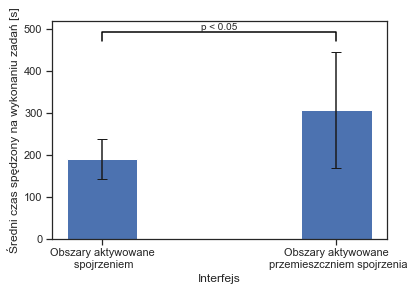

In [61]:
print(pingouin.normality(dv="Sum of time", group="Testowany interfejs", data=h6_data))
print("Nie zostały zachowany warunke normalności rozkładu zmiennej zależnej")
x = h6_data[h5_data["Testowany interfejs"] == "Obszary aktywowane spojrzeniem"]['Sum of time']
y = h6_data[h5_data["Testowany interfejs"] == "Obszary aktywowane przemieszczeniem spojrzenia"]['Sum of time']
print(pingouin.ttest(x=x, 
                     y=y,
                     paired=True, tail='two-sided'))
print("Istotne różnice pomiędzy grupami")
print("Obszary aktywowane spojrzeniem:", x.mean()/1000, " +-", x.std()/1000)
print("Obszary aktywowane przemieszczeniem spojrzenia:", y.mean()/1000, " +-", y.std()/1000)

x = h6_data['Testowany interfejs'].unique()
y = np.array([ np.array(h6_data[h6_data['Testowany interfejs'] == a]['Sum of time'].mean()/1000) for a in x])
yerr = np.array([ h6_data[h6_data['Testowany interfejs'] == a]['Sum of time'].std()/1000 for a in x])
a = plt.bar(['Obszary aktywowane\n spojrzeniem', 'Obszary aktywowane\n przemieszczniem spojrzenia'], y, color='b', yerr=yerr, width=0.3, capsize=5)
plt.ylabel('Średni czas spędzony na wykonaniu zadań [s]')
plt.xlabel('Interfejs')
hp.barplot_annotate_brackets(0,1, 'p < 0.05', np.arange(len(y)), y+140)
# hp.barplot_annotate_brackets(0,2, 'p < 0.01', np.arange(len(y)), y+200)
# hp.barplot_annotate_brackets(1,2, 'p < 0.01', np.arange(len(y)), y+120)
plt.savefig('time_spent.png', dpi=1000, paper='a4', bbox_inches='tight')
plt.show()


## Istotne różnice pomiędzy obszarami sterowanymi przemieszczeniem spojrzenia i pozostałymi

## Hipoteza 7: na ocenę interfejsu ma wpływ ilość popełnionych błędów podczas korzystania i czas przeznaczony na poszczególne zadania

             r  dof      pval           CI95%  power
rm_corr -0.702   17  0.000804  [-0.88, -0.36]  0.945
             r  dof      pval          CI95%  power
rm_corr  0.312   17  0.193989  [-0.17, 0.67]  0.261


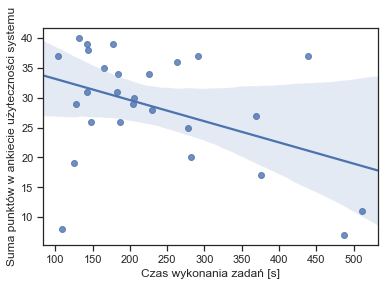

In [73]:
h7_data = EYETRACKING_SUMMARY
h7_data = h7_data[h7_data['Sum of time'] > 0]
x = h7_data['Sum of time']
y = h7_data['SUS']
print(pingouin.rm_corr(data=h7_data, x="SUS", y="Sum of time", subject="Kod badanego"))
print(pingouin.rm_corr(data=h7_data, x="SUS", y="Sum of errors", subject="Kod badanego"))

x = np.array(h7_data['Sum of time'].values, dtype=np.float)
y = np.array(h7_data['SUS'].values, dtype=np.int)

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
h7_data['Sum of time'] = h7_data['Sum of time']/1000
#plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
sns.regplot(x="Sum of time", y="SUS", data=h7_data);
plt.xlabel('Czas wykonania zadań [s]')
plt.ylabel('Suma punktów w ankiecie użyteczności systemu')
plt.savefig('regression.png', dpi=1000, paper='a4')
plt.show()


## Istotne statystycznie korelacja pomiędzy ilościa spędzonego czasu, a oceną intefejsu